# Classification Preprocessing and Dimensionality Reduction (PCA)

## Project Overview

This project presents a complete preprocessing workflow for a classification task.

It includes:

- Exploratory data analysis
- Correlation analysis
- Feature engineering
- Dimensionality reduction using PCA
- Feature scaling
- Train / validation / test split strategies

The goal is to demonstrate practical machine learning data preparation techniques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Exploration

The dataset is loaded and inspected to understand:

- Feature distributions
- Target variable structure ("label")
- Data consistency and potential issues

This step ensures proper preprocessing decisions.

In [3]:
df = pd.read_csv('nurse_data.csv')

In [4]:
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [5]:
df['id'].nunique()

18

## 2. Datetime Parsing and Aggregation

The dataset contains timestamps stored as text.  
We extract:

- `date_days` (calendar day)
- `date_time` (time of day)

Then we aggregate measurements at the (`id`, `date`, `time`) level using mean values.  
This reduces noise and ensures one consistent observation per time point.

In [6]:
df['date_days']=df['datetime'].apply(lambda x: x.split(' ')[0])
df['date_time']=df['datetime'].apply(lambda x: x.split(' ')[1].split('.')[0])

In [7]:
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label,date_days,date_time
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0,2020-07-08,14:03:00
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0,2020-07-08,14:03:00
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0,2020-07-08,14:03:00
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0,2020-07-08,14:03:00
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0,2020-07-08,14:03:00
...,...,...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0,2020-07-23,17:28:59
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0,2020-07-23,17:28:59
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0,2020-07-23,17:28:59
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0,2020-07-23,17:28:59


In [8]:
df=df.groupby(['id','date_days', 'date_time']).agg({'X':'mean',
                                                    'Y':'mean',
                                                    'Z':'mean',
                                                    'EDA':'mean',
                                                    'HR':'mean',
                                                    'TEMP':'mean',
                                                    'label':'mean'}).reset_index()

In [9]:
df['date_days']=pd.to_datetime(df['date_days'], format='%Y-%m-%d')

### Converting Time to a Numeric Feature

Many machine learning models require numeric features.  
To represent time-of-day numerically, we convert `HH:MM:SS` into total seconds since midnight (`date_time_seconds`).

In [10]:
def czas_do_liczby(time_str):
    czas_object = datetime.strptime(time_str, "%H:%M:%S").time()
    liczba_sekund = czas_object.second + czas_object.minute * 60 + czas_object.hour * 3600
    return liczba_sekund

In [11]:
df['date_time_seconds'] = df['date_time'].apply(lambda x: czas_do_liczby(x))

In [12]:
df

,id,date_days,date_time,X,Y,Z,EDA,HR,TEMP,label,date_time_seconds
0,15,2020-07-08,13:09:00,-38.43750,-46.62500,-14.09375,2.663418,77.27,32.65,2.0,47340
1,15,2020-07-08,13:09:01,-35.21875,-46.28125,-30.71875,2.796692,77.10,32.65,2.0,47341
2,15,2020-07-08,13:09:02,-41.53125,-44.25000,-30.43750,3.062683,76.93,32.65,2.0,47342
3,15,2020-07-08,13:09:03,-38.78125,-3.75000,-46.34375,3.075846,76.77,32.65,2.0,47343
4,15,2020-07-08,13:09:04,-45.34375,-31.59375,-36.59375,3.241798,76.55,32.68,2.0,47344
...,...,...,...,...,...,...,...,...,...,...,...
356561,F5,2020-07-23,17:28:56,-20.00000,-62.46875,8.43750,3.414566,88.52,33.75,2.0,62936
356562,F5,2020-07-23,17:28:57,-4.34375,-55.37500,19.50000,3.282011,88.47,33.77,2.0,62937
356563,F5,2020-07-23,17:28:58,4.71875,-59.18750,17.00000,3.167067,88.40,33.77,2.0,62938
356564,F5,2020-07-23,17:28:59,-15.71875,-52.96875,25.65625,3.388311,88.37,33.77,2.0,62939


In [13]:
from collections import Counter

Counter(df['id'])

Counter({'E4': 46464,
         '7A': 42052,
         83: 40979,
         'DF': 28388,
         '5C': 27070,
         '6B': 25570,
         'CE': 25447,
         'BG': 19035,
         '6D': 18483,
         'EG': 17164,
         94: 16398,
         'F5': 14784,
         '8B': 13257,
         15: 8199,
         '7E': 7927,
         '83': 1942,
         '94': 1934,
         '15': 1473})

## 3. Target Variable Exploration

We inspect the distribution of the target variable (`label`) to check for class imbalance.  
Class imbalance affects model evaluation and determines whether stratified splitting is needed.

<Axes: xlabel='label', ylabel='Count'>

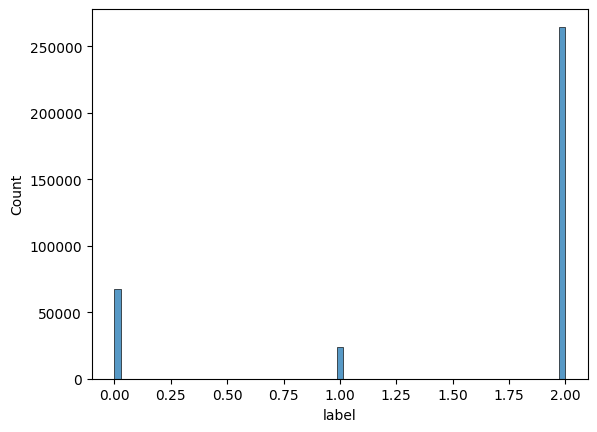

In [14]:
sns.histplot(df['label'])

### Example Time Series for a Single Subject

To better understand the signal behavior, we visualize measurements for one selected subject and one day.  
This provides intuition about variability and potential noise patterns.

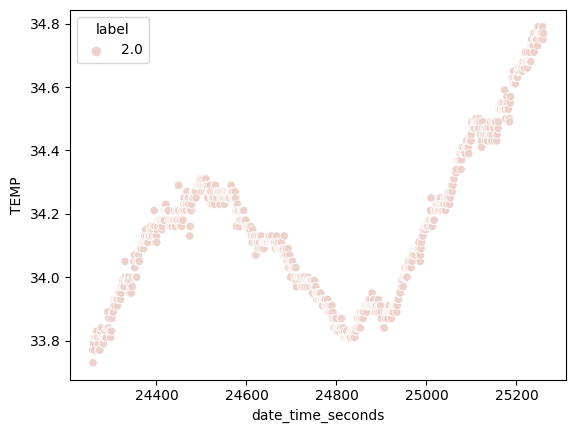

In [16]:
sns.scatterplot(df.loc[df['id']==83].loc[df['date_days']==df.loc[df['id']==83]['date_days'].values[0]],
             x='date_time_seconds',
            y='TEMP',
            hue='label')
plt.show()

## 4. Feature Distribution Analysis

We explore distributions of key numerical features to detect:

- Skewness and heavy tails
- Potential outliers
- Values that may benefit from transformation (e.g., log)

Understanding distributions is crucial before applying PCA and scaling.

In [18]:
def hist_plots(series):
    sns.histplot(series, kde=True)
    plt.show()

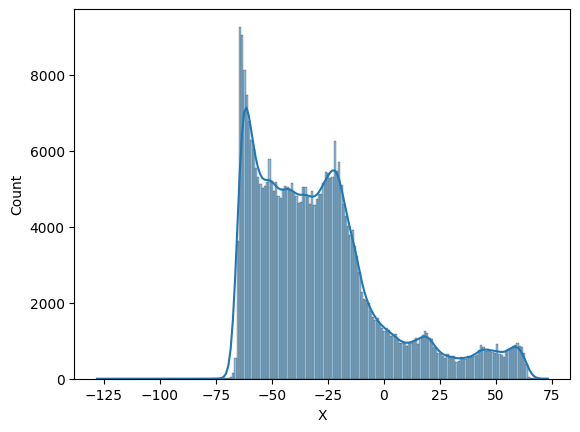

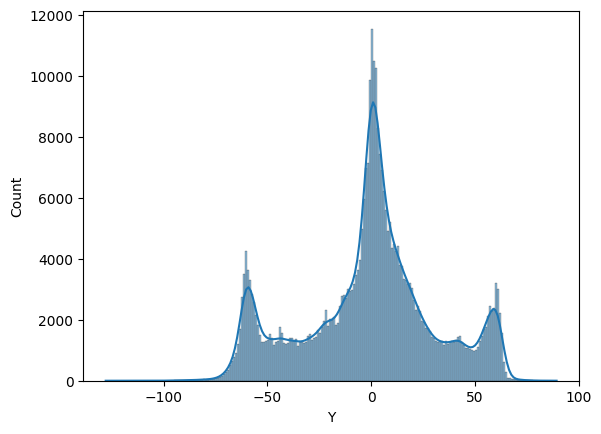

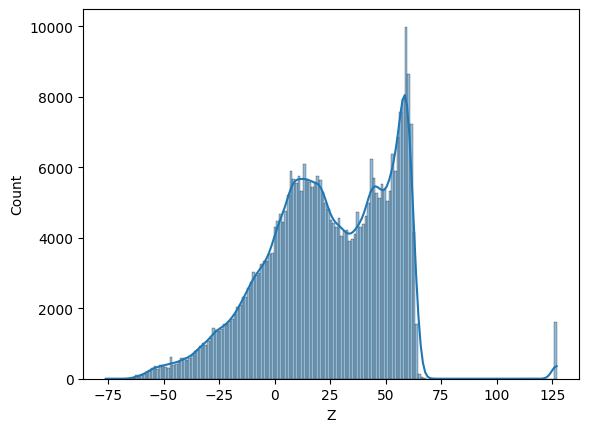

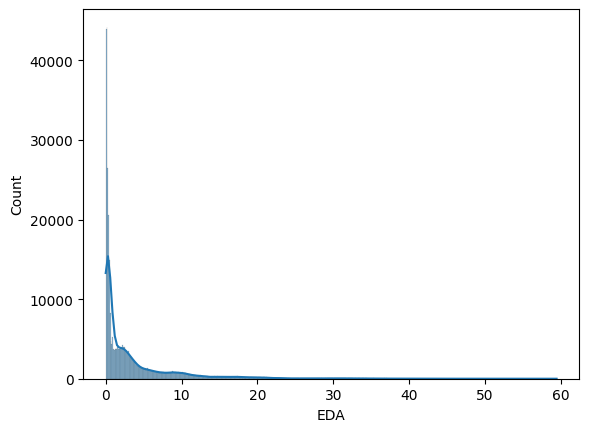

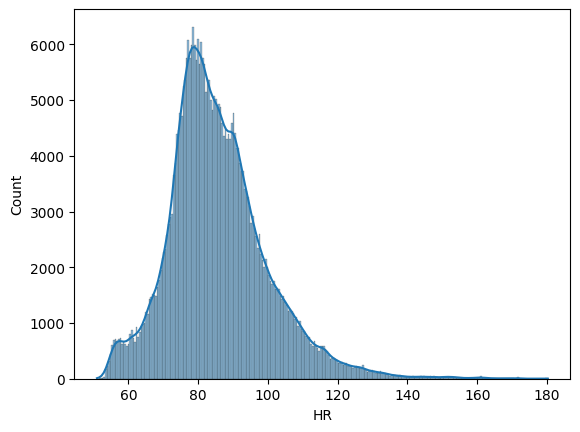

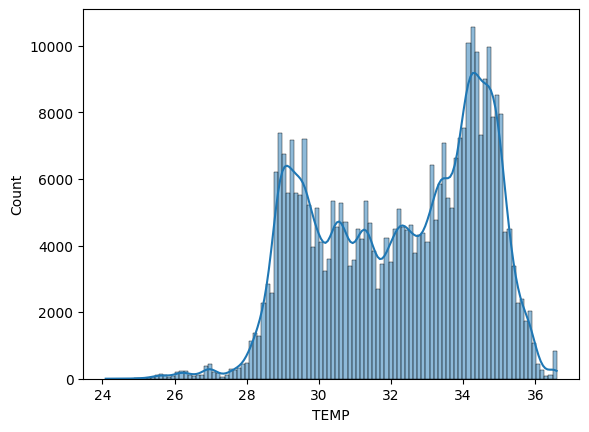

In [19]:
for col in ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']:
    hist_plots(df[col])

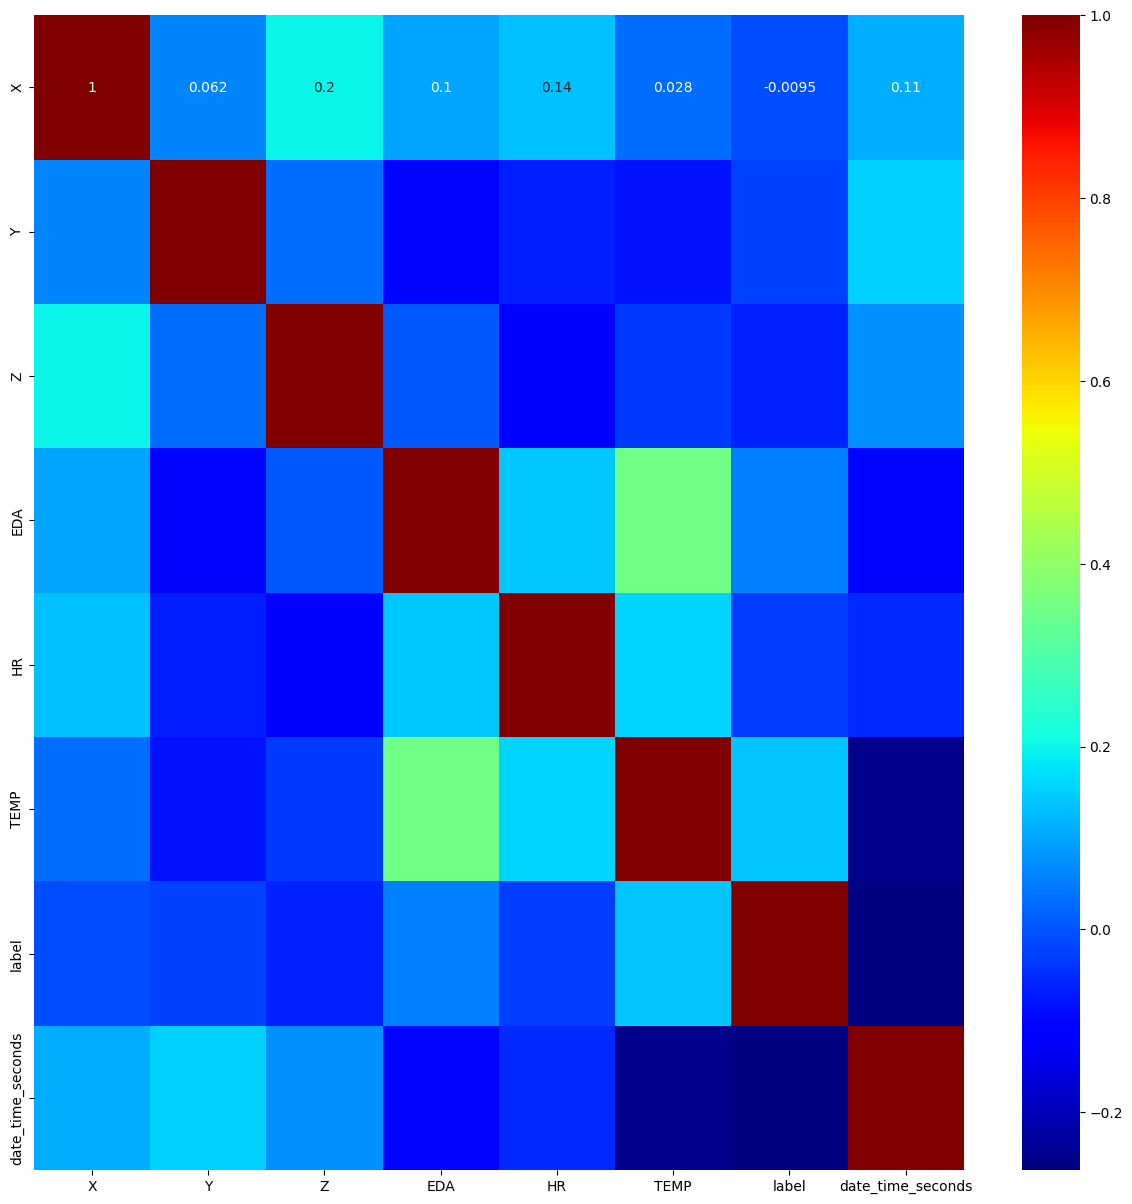

In [20]:
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),
           annot=True,
           cmap='jet')
plt.show()

### Correlation Interpretation

Highly correlated features may introduce redundancy and multicollinearity.  
This motivates dimensionality reduction approaches such as PCA, which can compress correlated variables into fewer components.

## 5. Feature Engineering

We enrich the dataset by creating additional features that may help classification:

- `weekday` (day name)
- `time_of_day` (coarse time bucket)
- Derived behavioral features (e.g., time spent at work)

Categorical features are encoded using one-hot encoding to make them ML-ready.

In [21]:
def time_of_day(hour):
    if hour>'21:00:00':
        return 'night'
    elif hour<'05:00:00':
        return 'night'
    elif hour<'11:00:00':
        return 'morning'
    elif hour<'17:00:00':
        return 'day'
    else:
        return 'evening'

In [22]:
from tqdm import tqdm

def time_in_work(df):
    df['time_in_work']=0
    for i in tqdm(df['id'].unique()):
        for day in df.loc[df['id']==i]['date_days'].unique():
            ind=df.loc[df['id']==i].loc[df['date_days']==day].index
            start=df.loc[ind, 'date_time_seconds'].min()
            for j in ind:
                df.loc[j, 'time_in_work']=df.loc[j, 'date_time_seconds']-start
    return df

In [23]:
df['weekday']=df['date_days'].apply(lambda x: x.day_name())
df['time_of_day']=df['date_time'].apply(lambda x: time_of_day(x))
df['EDA_log']=df['EDA'].apply(lambda x: np.log1p(x))

df=time_in_work(df)
df['time_in_work_log']=df['time_in_work'].apply(lambda x: np.log1p(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:47<00:00,  6.00s/it]


In [24]:
df=pd.concat([df, pd.get_dummies(df[['weekday','time_of_day']])],
             axis=1)

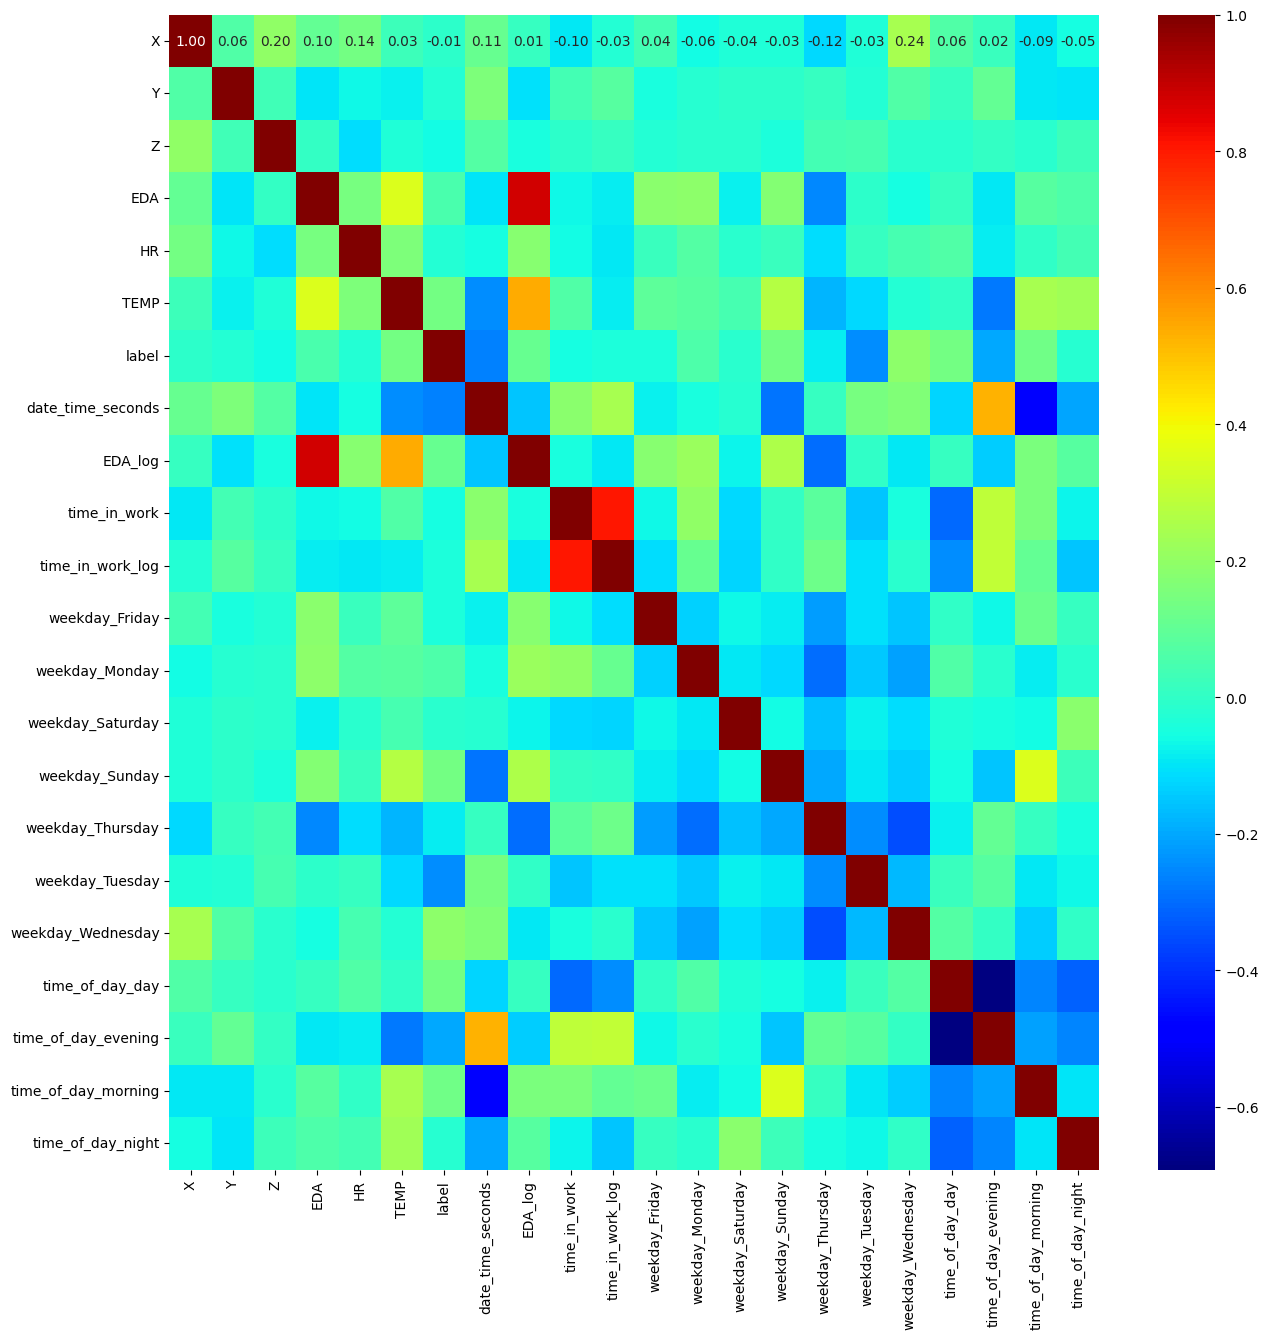

In [25]:
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),
            annot=True, fmt=".2f",
           cmap='jet')
plt.show()

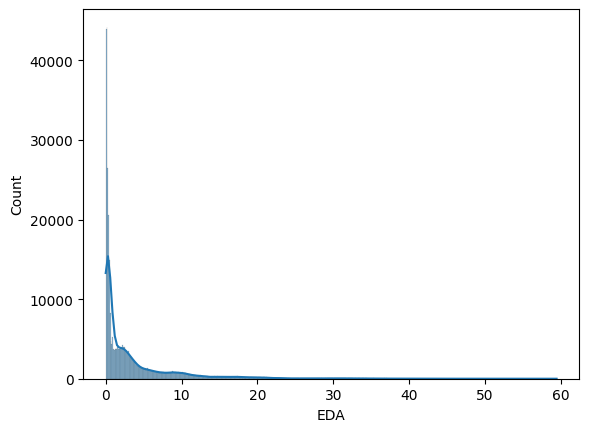

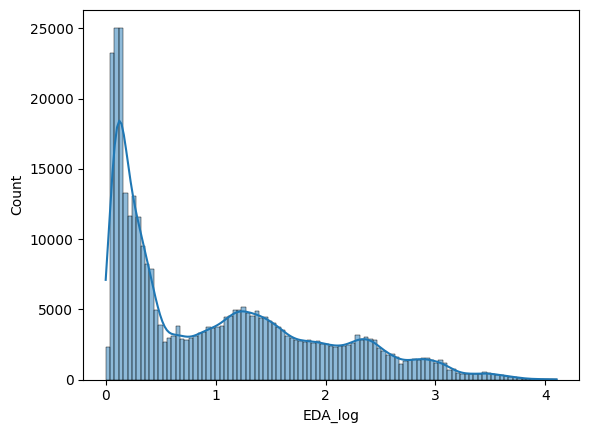

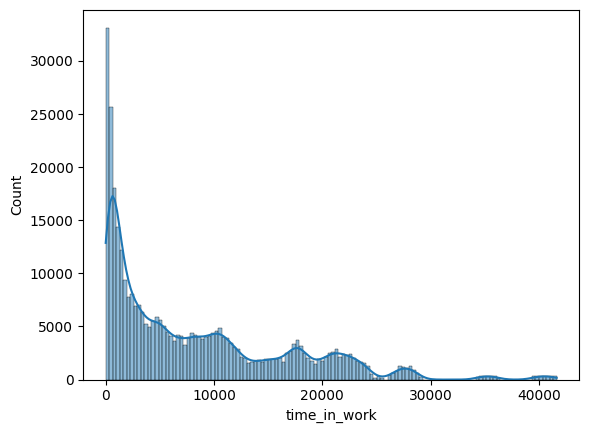

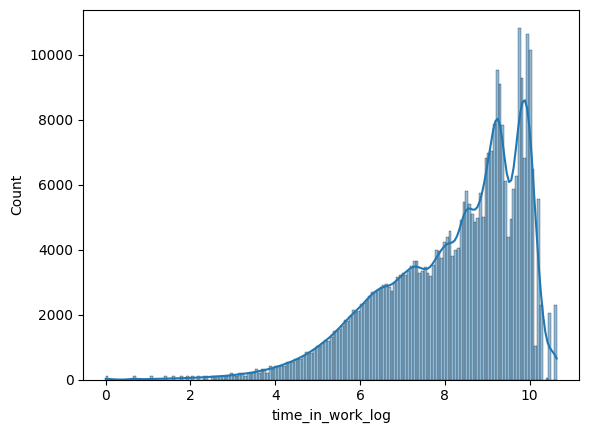

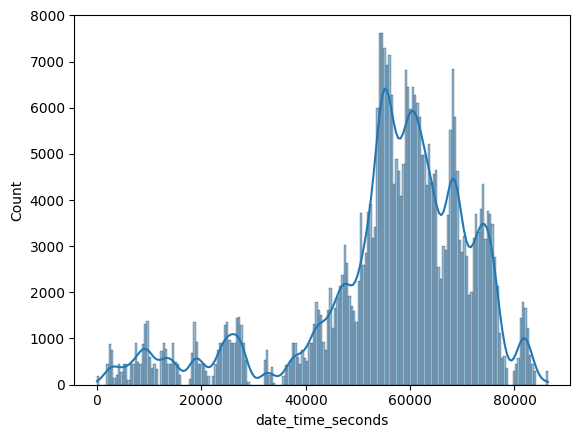

In [26]:
for col in ['EDA', 'EDA_log', 'time_in_work', 'time_in_work_log', 'date_time_seconds']:
    hist_plots(df[col])

## 6. Data Quality Checks

We verify:
- Missing values
- Infinite values

This step ensures that downstream steps (scaling, PCA, splitting) will not fail or become biased.

In [27]:
df.isna().sum()

id                     0
date_days              0
date_time              0
X                      0
Y                      0
Z                      0
EDA                    0
HR                     0
TEMP                   0
label                  0
date_time_seconds      0
weekday                0
time_of_day            0
EDA_log                0
time_in_work           0
time_in_work_log       0
weekday_Friday         0
weekday_Monday         0
weekday_Saturday       0
weekday_Sunday         0
weekday_Thursday       0
weekday_Tuesday        0
weekday_Wednesday      0
time_of_day_day        0
time_of_day_evening    0
time_of_day_morning    0
time_of_day_night      0
dtype: int64

In [28]:
df.isin([np.inf, -np.inf]).sum()

id                     0
date_days              0
date_time              0
X                      0
Y                      0
Z                      0
EDA                    0
HR                     0
TEMP                   0
label                  0
date_time_seconds      0
weekday                0
time_of_day            0
EDA_log                0
time_in_work           0
time_in_work_log       0
weekday_Friday         0
weekday_Monday         0
weekday_Saturday       0
weekday_Sunday         0
weekday_Thursday       0
weekday_Tuesday        0
weekday_Wednesday      0
time_of_day_day        0
time_of_day_evening    0
time_of_day_morning    0
time_of_day_night      0
dtype: int64

## 7. Additional Derived Features (Custom Enrichment)

To improve feature representation, we engineer additional variables:

- `EDA_TEMP_diff`: relationship between EDA and temperature
- `hand_distance`: magnitude of motion from X/Y/Z
- `EDA_change_rate`: rate of change in EDA signal
- `activity_percentage`: approximate activity share of the day

These features may improve class separation for classification tasks.

In [62]:
df['EDA_TEMP_diff'] = df['EDA'] - df['TEMP']

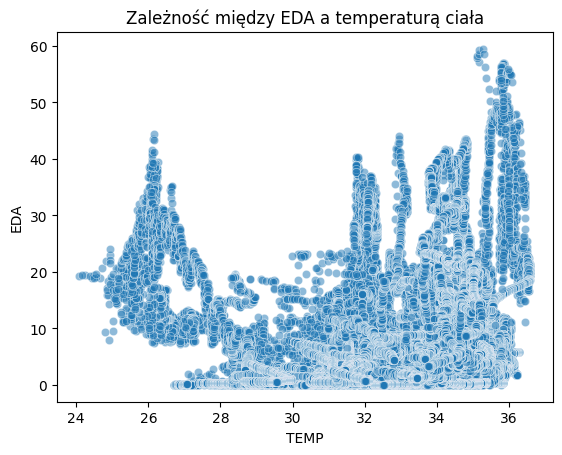

In [ ]:
sns.scatterplot(data=df, x='TEMP', y='EDA', alpha=0.5)
plt.title("Zależność między EDA a temperaturą ciała")
plt.xlabel("TEMP")
plt.ylabel("EDA")
plt.show()

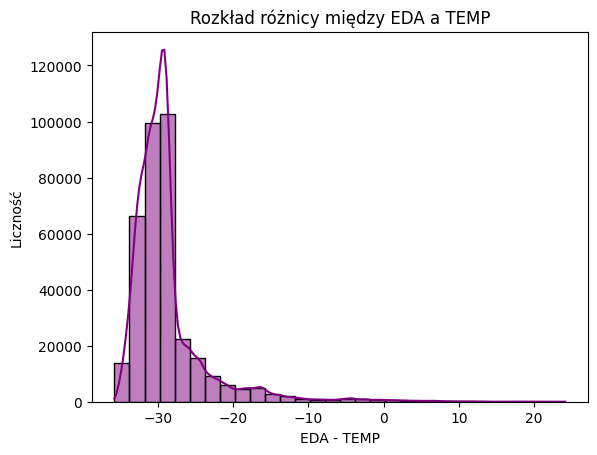

In [ ]:
sns.histplot(data=df, x='EDA_TEMP_diff', kde=True, bins=30, color="purple")
plt.title("Rozkład różnicy między EDA a TEMP")
plt.xlabel("EDA - TEMP")
plt.ylabel("Liczność")
plt.show()

In [70]:
df['hand_distance'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)

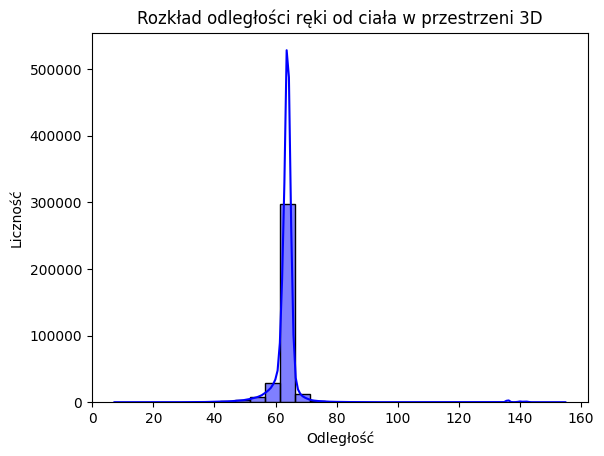

In [ ]:
sns.histplot(data=df, x='hand_distance', kde=True, bins=30, color="blue")
plt.title("Rozkład odległości ręki od ciała w przestrzeni 3D")
plt.xlabel("Odległość")
plt.ylabel("Liczność")
plt.show()

In [76]:
df['EDA_change_rate'] = df['EDA'].diff().fillna(0)

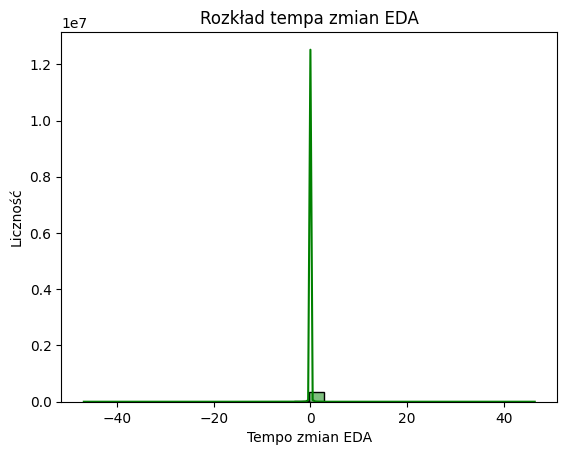

In [78]:
sns.histplot(data=df, x='EDA_change_rate', kde=True, bins=30, color="green")
plt.title("Rozkład tempa zmian EDA")
plt.xlabel("Tempo zmian EDA")
plt.ylabel("Liczność")
plt.show()

In [80]:
df['activity_percentage'] = (df['time_in_work'] / (24 * 3600)) * 100

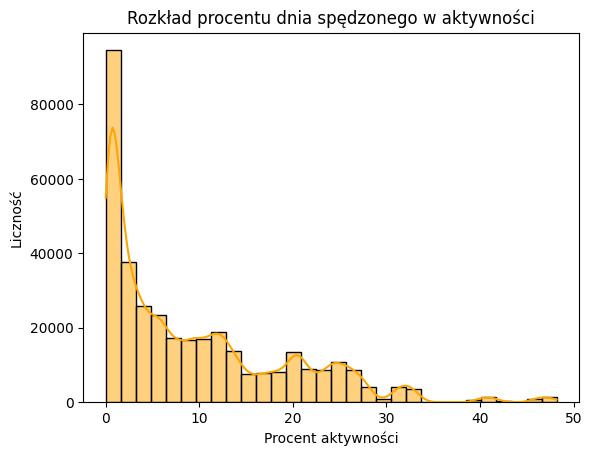

In [ ]:
sns.histplot(data=df, x='activity_percentage', kde=True, bins=30, color="orange")
plt.title("Rozkład procentu dnia spędzonego w aktywności")
plt.xlabel("Procent aktywności")
plt.ylabel("Liczność")
plt.show()

## Dimensionality Reduction – PCA

Principal Component Analysis (PCA) is used to:

- Reduce dimensionality
- Remove multicollinearity
- Preserve maximum variance

PCA transforms original features into orthogonal components.

In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

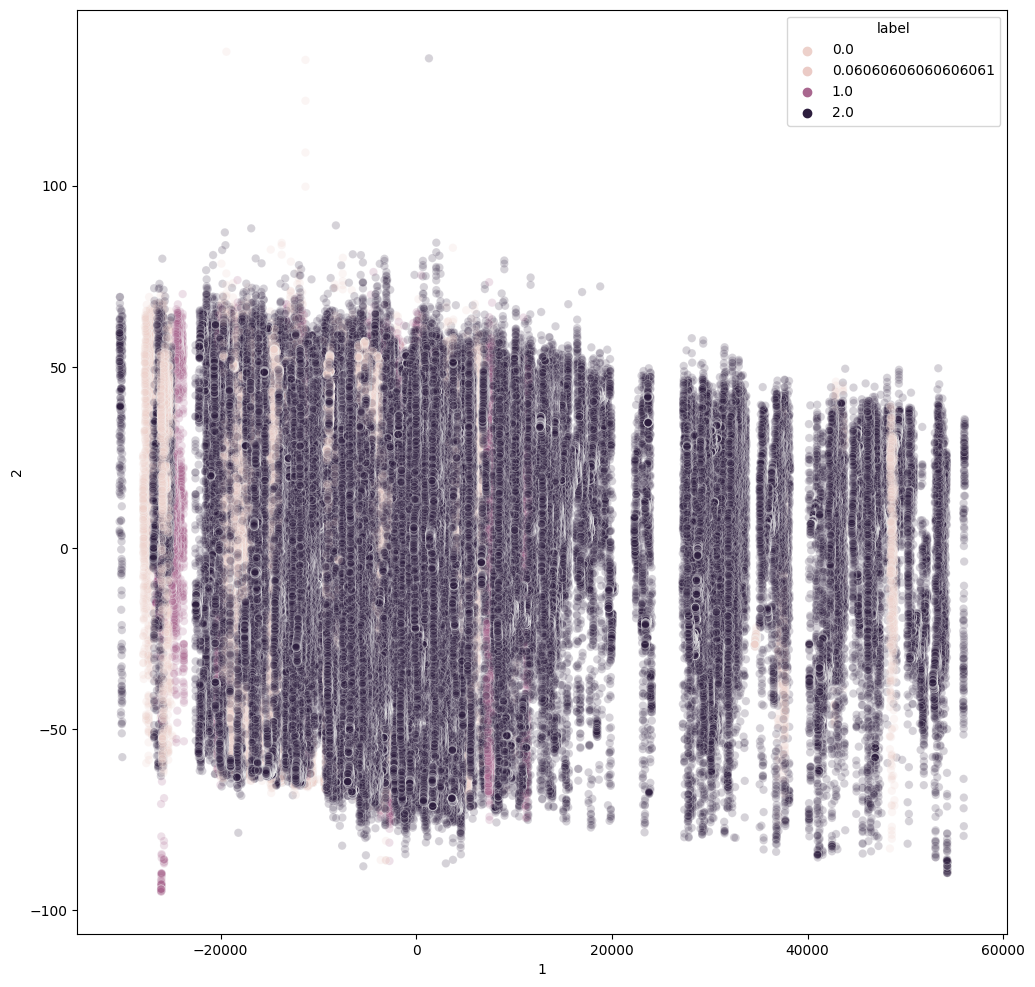

In [ ]:
pca=PCA(n_components=2)
pca.fit(df.drop(['label', 'id', 'date_days', 'date_time', 'weekday', 'time_of_day', 'EDA', 'time_in_work'], axis=1))
df_pca = pca.transform(df.drop(['label', 'id', 'date_days', 'date_time', 'weekday', 'time_of_day', 'EDA', 'time_in_work'], axis=1))
df_pca=pd.DataFrame(df_pca, columns=[1,2])

df_pca['label']=list(df['label'])

fig,ax = plt.subplots(figsize=(12,12))
sns.scatterplot(df_pca,
          x=1,
          y=2,
          hue='label',
          alpha=0.2)
plt.show()

### PCA Interpretation

We examine the explained variance ratio to understand how much information is preserved by the selected components.  
If a small number of components captures a large portion of variance, PCA can simplify the feature space without major information loss.

## 8. Scaling and PCA (Impact of Feature Magnitude)

PCA is sensitive to feature scales.  
Without scaling, features with larger numeric ranges may dominate principal components.

We apply `MinMaxScaler` (0–1 normalization) and repeat PCA to compare results.

In [88]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(['label', 'id', 'date_days', 'date_time', 'weekday', 'time_of_day', 'EDA', 'time_in_work'], axis=1))

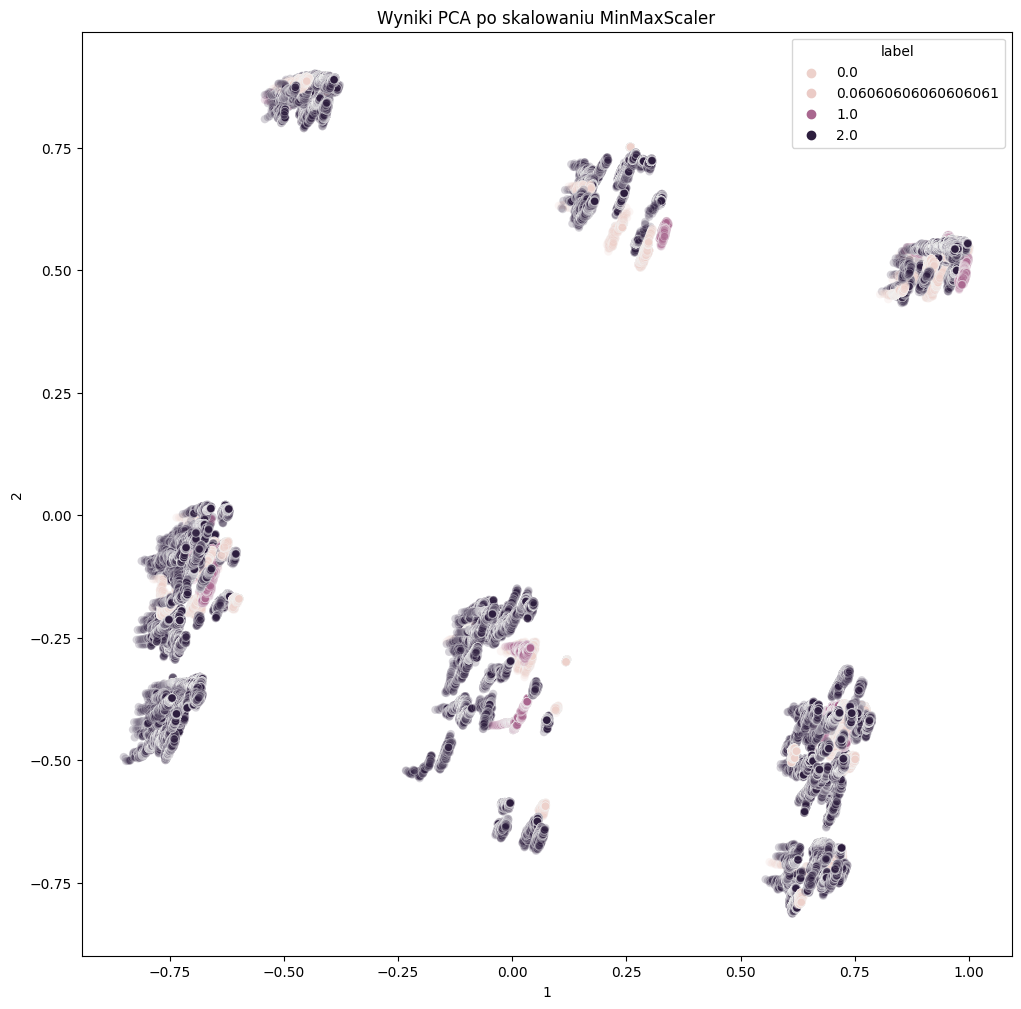

In [ ]:
pca_scaled = PCA(n_components=2)
df_pca_scaled = pca_scaled.fit_transform(scaled_data)
df_pca_scaled = pd.DataFrame(df_pca_scaled, columns=[1, 2])
df_pca_scaled['label'] = list(df['label'])

fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(
    data=df_pca_scaled,
    x=1,
    y=2,
    hue='label',
    alpha=0.2
)
plt.title("Wyniki PCA po skalowaniu MinMaxScaler")
plt.show()

### Effect of Scaling on PCA

After scaling:
- Each feature contributes more evenly
- PCA components become more representative of the overall structure
- Explained variance distribution often changes

This confirms why scaling is typically required before PCA.

## 9. Train / Validation / Test Split Strategy

For classification tasks, we split the data into:

- Train set (model learning)
- Validation set (tuning and model selection)
- Test set (final unbiased evaluation)

We also compare random split vs stratified split to preserve class proportions.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['label'], axis=1)  
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Rozmiar zbioru treningowego: {X_train.shape[0]}")
print(f"Rozmiar zbioru walidacyjnego: {X_valid.shape[0]}")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]}")

Rozmiar zbioru treningowego: 249596
Rozmiar zbioru walidacyjnego: 53485
Rozmiar zbioru testowego: 53485


In [ ]:
def print_class_distribution(y, name):
    distribution = y.value_counts(normalize=True) * 100
    print(f"{name} class distribution:")
    print(distribution)
    print("-" * 30)

print_class_distribution(y, "Full Dataset")
print_class_distribution(y_train, "Train Dataset")
print_class_distribution(y_valid, "Validation Dataset")
print_class_distribution(y_test, "Test Dataset")

Full Dataset class distribution:
2.000000    74.255538
0.000000    18.960305
1.000000     6.783877
0.060606     0.000280
Name: label, dtype: float64
------------------------------
Train Dataset class distribution:
2.000000    74.215132
0.000000    19.004311
1.000000     6.780157
0.060606     0.000401
Name: label, dtype: float64
------------------------------
Validation Dataset class distribution:
2.0    74.198373
0.0    18.923063
1.0     6.878564
Name: label, dtype: float64
------------------------------
Test Dataset class distribution:
2.0    74.501262
0.0    18.792185
1.0     6.706553
Name: label, dtype: float64
------------------------------
